### Introduction

This dataset is rich with wine description information, it will be intesting to see what common things were said about the wines.

* Goal to cluster or group average representation of the descriptions, that is, t odiscover which words ten to appear together. 

* Further we want to see if there are certain wine variety descriptiosn more prevalent than others in each of the clusters. 

* We can then gain some insight on how some wine types are generally reported

* We will be exploring all this using the K-Meaning unsupervised machien learning algorithm

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [9]:
winedf = pd.read_csv('winemag-data_first150k.csv', encoding='utf-8')
winedf.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


### Exploratory Data Analysis

The first check is to see where values are missing; the information in this file is for the most part complete.

Luckily there isn't any data missing in the description and variety columns, which are the main columns we will need for this analysis. 

There are 5 missing values for country that can be filled in by looking at which winery was listed with these missing values, then looked up other entries with that same winery to determine country. 


In [10]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


As we can see, there are some duplicates with the descriptions. Although the duplicates won't affect the averaging used to find the kMeans centroids, we will still remove them because we only need unique descriptions to perform the clustering. 

Note that dropping duplicates will still keep one of those entries in the set.

In [11]:
winedf[winedf['description'].duplicated(keep = False)].sort_values('description').head(8)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
147725,147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
62345,62345,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
74993,74993,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
18803,18803,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
26530,26530,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
84730,84730,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
53110,53110,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
107351,107351,France,. From a small south-facing parcel next to the...,Trie Spéciale,91,38.0,Loire Valley,Savennières,NaN,Chenin Blanc,Domaine des Baumard


In [12]:
winedf = winedf.drop_duplicates('description')

If we list out all the unique varieties in this dataset, we find that there are a TON of them here. However, with kMeans, we want to limit the number of wine varieties to the number of clusters.

Ideally the algorithm can find individual clusters or average descriptions for each type of wine. If the wine varieties are limited to those where there are more than 1500 entries in the dataset, 15 types are narrowed down. Fifteen clusters sounds reasonable to start off with, so we will create a new dataframe and use descriptions only from these 15 kinds of wines.

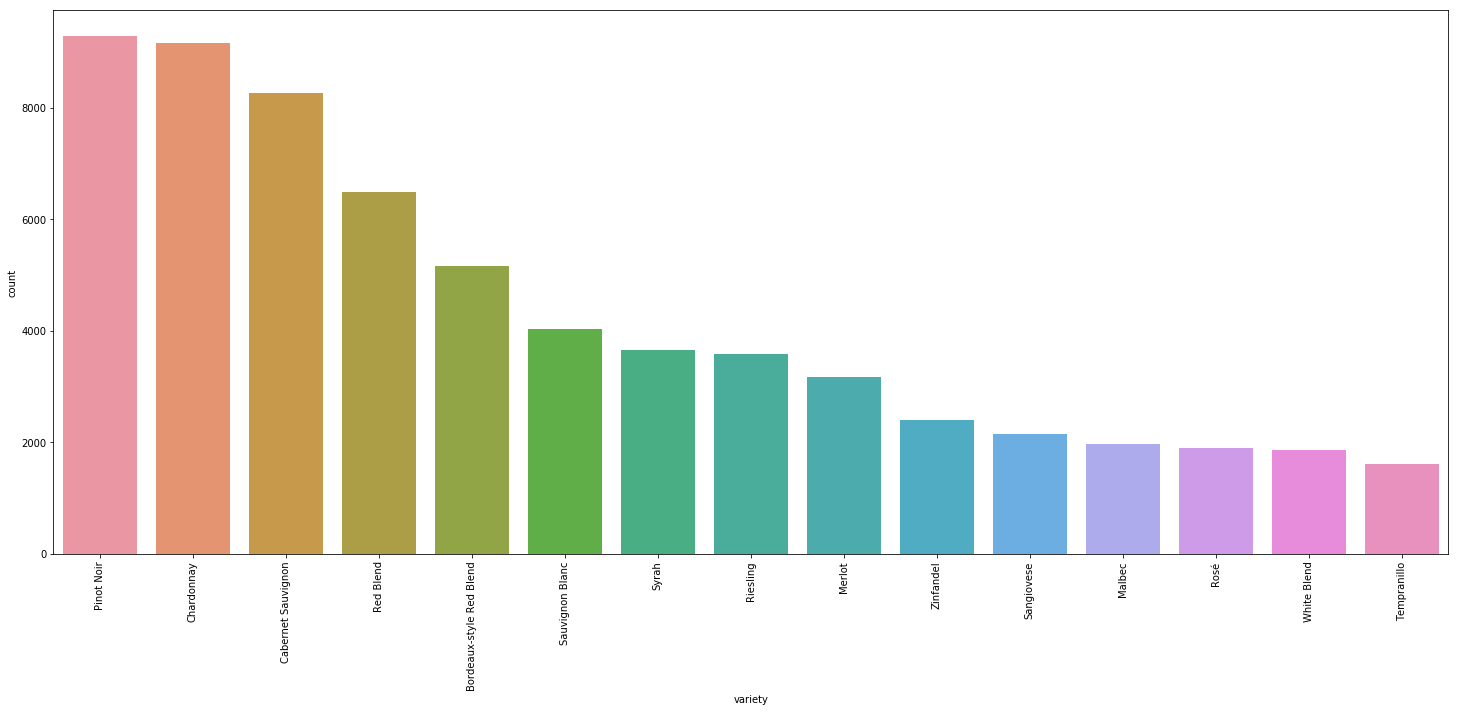

In [14]:
variety_df = winedf.groupby('variety').filter(lambda x: len(x) > 1500)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

A more clear viewing of the 15 wine varieties - looks like some of the more popular wines are included!

In [15]:
variety_df['variety'].unique()

array([u'Cabernet Sauvignon', u'Sauvignon Blanc', u'Pinot Noir',
       u'Chardonnay', u'Tempranillo', u'Malbec', u'Ros\xe9', u'Syrah',
       u'Sangiovese', u'Red Blend', u'Riesling', u'White Blend',
       u'Zinfandel', u'Bordeaux-style Red Blend', u'Merlot'], dtype=object)

### Natural Language Processing

In Natural Language Processing, there is a term called stop words. These are tokens (NLP's definition for characters or groups of characters including words, punctuation, etc.) that are used frequently in the texts of the group of documents, or corpus, but don't really give much meaning or context to what they're being used in; they're generally used more for grammatical purposes. Examples of stop words are 'the', 'is', 'are', etc. 

There might be additional words that do not give much meaning to the text depending on what the situation is. I will discuss more stop words I could have used for this analysis in the conclusion but for now, I will use the English stop words list that is defaulted in the sklearn library in addition to some punctuation. When our text is being vectorized, the tokens included in the stop words list will not be included in the vectorization. Having stop words also helps us keep down the feature space.

To vectorize the tokens of each description, sklearn has a count vectorizer or tf-idf (term frequency-inverse document frequency) vectorizer object that will do all of this for us. The count vectorizer simply creates a vector of counts of each word in each description. 

The tf-idf vectorizer, on the otherhand, takes it further by creating frequency vectors that account for how important each token is relative to the document it is in AND relative to the corpus. A word might appear more than others in the same document, making it important to that piece of text. However, if that highly frequented word is in many of the other documents in the corpus, then that word does not really help distinguish that single document from the others. For this analysis, I have used the tf-idf vectorizer.

In [16]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

/Library/Python/2.7/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Both the count vectorizer and tf-idf vectorizer in sklearn have a method called get_feature_names(). This returns a list of all the tokens in the corpus that were vectorized for each document (note that each document will not contain all of the words extracted from the entire group so the entries in their vectors will be 0 for these tokens).

Below is a subset of the tokens that were vectorized. You can see that different forms of words show up in the list such as 'abrasive', 'abrasiveness', and 'absorb', 'absorbed', 'absorbs'. In many cases these different forms of the same word are redundant, and yes, you guessed right, unnecessarily extend our feature space. Sklearn's word vectorizers do not account for these unnecessary forms by default and that is why we see them in the list below.

In [17]:
word_features = vectorizer.get_feature_names()
word_features[550:575]

[u'aboard',
 u'abondante',
 u'abound',
 u'abounding',
 u'abounds',
 u'abouriou',
 u'abracadabra',
 u'abrasive',
 u'abrasiveness',
 u'abreu',
 u'abroad',
 u'abrupt',
 u'abruptly',
 u'abruzzi',
 u'abruzzo',
 u'absence',
 u'absent',
 u'absolute',
 u'absolutely',
 u'absorb',
 u'absorbed',
 u'absorbs',
 u'abstberg',
 u'absurd',
 u'abtsberg']

Fortunately the Natural Language Toolkit (NLTK) library provides many methods to stem/lemmatize, or reduce words to their root forms. Various stemmers and lemmatizers reduce these words to root forms differently because there might be cases where some forms do indeed produce different meanings. It's a bit overwhelming what NLTK provides but for now I am using the SnowballStemmer. 

We can override the default settings to the tf-idfvectorizer by writting our own function that performs the stemming and any other text processing you want to execute. Here I have used regular expressions with another NLTK tokenizer that will further limit the tokens to vectorize.

Regular expressions are a powerful tool in finding patterns in strings, which helps us find the tokens we want. 

In [18]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

After writing the function, I pass it through as an argument when instantiating the vectorizer. We can see that those repeated forms I mentioned above are now gone and only the root form is present thanks to the stemming we added :)

In [19]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]

[u"'s",
 u"a'",
 u"a'plenti",
 u'aa',
 u'aah',
 u'aand',
 u'aaron',
 u'abacela',
 u'abad',
 u'abadia',
 u'abandon',
 u'abarbanel',
 u'abbacchio',
 u'abbay',
 u'abbey',
 u'abbinar',
 u'abboccato',
 u'abbott',
 u'abbrevi',
 u'abbuoto',
 u'abc',
 u'abeill',
 u'abeja',
 u'abernathi',
 u'aberr',
 u'abetina',
 u'abey',
 u'abil',
 u'abl',
 u'abli',
 u'abnorm',
 u'aboard',
 u'abondant',
 u'abound',
 u'abouriou',
 u'abov',
 u'abracadabra',
 u'abras',
 u'abreu',
 u'abroad',
 u'abrupt',
 u'abruzzi',
 u'abruzzo',
 u'absenc',
 u'absent',
 u'absolut',
 u'absorb',
 u'abstberg',
 u'absurd',
 u'abtsberg']

So far I've adjusted the stop words, included stemming, and further limited our token feature space with regular expressions. Below, I take it one step further by adjusting the max_features parameter in the tf-idf vectorizer, which selects only the top max_features tokens ordered by their frequencies in the corpus to be included in the vectorizing.

In [20]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

### kMeans Clustering

Now that the text preprocessing is done, I can finally apply the kMeans algorithm to cluster our description vectors. I won't list out all the steps to how the kMeans algorithm works but one thing to know is that in order for kMeans needs to initialize k centroids in order for it to start finding the k clusters. 

There are a few approaches to how the centroids are initilized but it typically involves some sort of randomization. Because of this randomness, the algorithm is not deterministic meaning that it might come up with different clusters if we run it multiple times. Therefore, it is wise to run the algorithm multiple times and have it choose the version that has the lowest within cluster variance, which I won't describe here. 

Luckily sklearn does this for us already with the n_init parameter. The default is 10 different centroid initializations and returns the best version but I lowered it to 5 so it would run faster.

In [21]:
kmeans = KMeans(n_clusters = 15, n_init = 5, n_jobs = -1)
kmeans.fit(X3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The model has a cluster centers attribute that returns the coordinates of each of the k cluster centroids. Each token in the vectorizer we created earlier has a dimension or coordinate in the centroid and represents its relative frequency within that cluster. So to find the words with the highest frequency in a cluster, we have to locate the indices of the highest values of the centroid, which then correspond to the indices of the tokens in the vectorizer.

Below I find the indices of the top ten frequented words in each cluster and print these words out.

Now we can see 15 groups of words that tend to be used with each other in our wine descriptions. Cluster 6, for example, seems to describe wines that are more citrusy and acidic.

In [22]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : blanc, sauvignon, flavor, citrus, crisp, acid, green, lime, grapefruit, wine
1 : blackberri, currant, dri, tannin, flavor, rich, cherri, oak, wine, drink
2 : wine, fresh, acid, fruiti, fruit, attract, light, drink, crisp, soft
3 : chardonnay, pineappl, butter, oak, toast, flavor, vanilla, acid, rich, pear
4 : wine, fruit, flavor, cherri, finish, tannin, spice, oak, vineyard, aroma
5 : berri, aroma, finish, plum, flavor, palat, herbal, feel, nose, fruit
6 : sampl, barrel, wine, tannin, fruit, ripe, wood, structur, juici, veri
7 : black, cherri, palat, aroma, tannin, fruit, plum, dark, finish, pepper
8 : red, fruit, cherri, wine, flavor, berri, aroma, spice, palat, finish
9 : wine, age, fruit, wood, structur, tannin, year, rich, ripe, firm
10 : citrus, peach, finish, white, flavor, lemon, lime, palat, wine, acid
11 : appl, green, flavor, pear, finish, palat, citrus, wine, acid, aroma
12 : cabernet, sauvignon, blend, merlot, franc, petit, verdot, wine, syrah, cherri
13 : pinot, noir, 

Now we can take a deeper look at each cluster. We can see if there is one wine variation more prevalant than others in each of the clusters the kMeans algorithm found.

Below a heatmap maps out each of the 15 wine variations and their counts in each of the 15 clusters. It appears that Cabernet Sauvignon is very present in cluster 13, Chardonay in cluster 12, Pinot Noir in cluster 0, and Riesling in cluster 1. Zinfandel might be highly described by cluster 8 since there are a lot of entries for this type in this cluster relative to the total number of entries in the dataset. The words associated in these clusters were very common in desribing these wines.

In [23]:
variety_df['cluster'] = kmeans.labels_

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


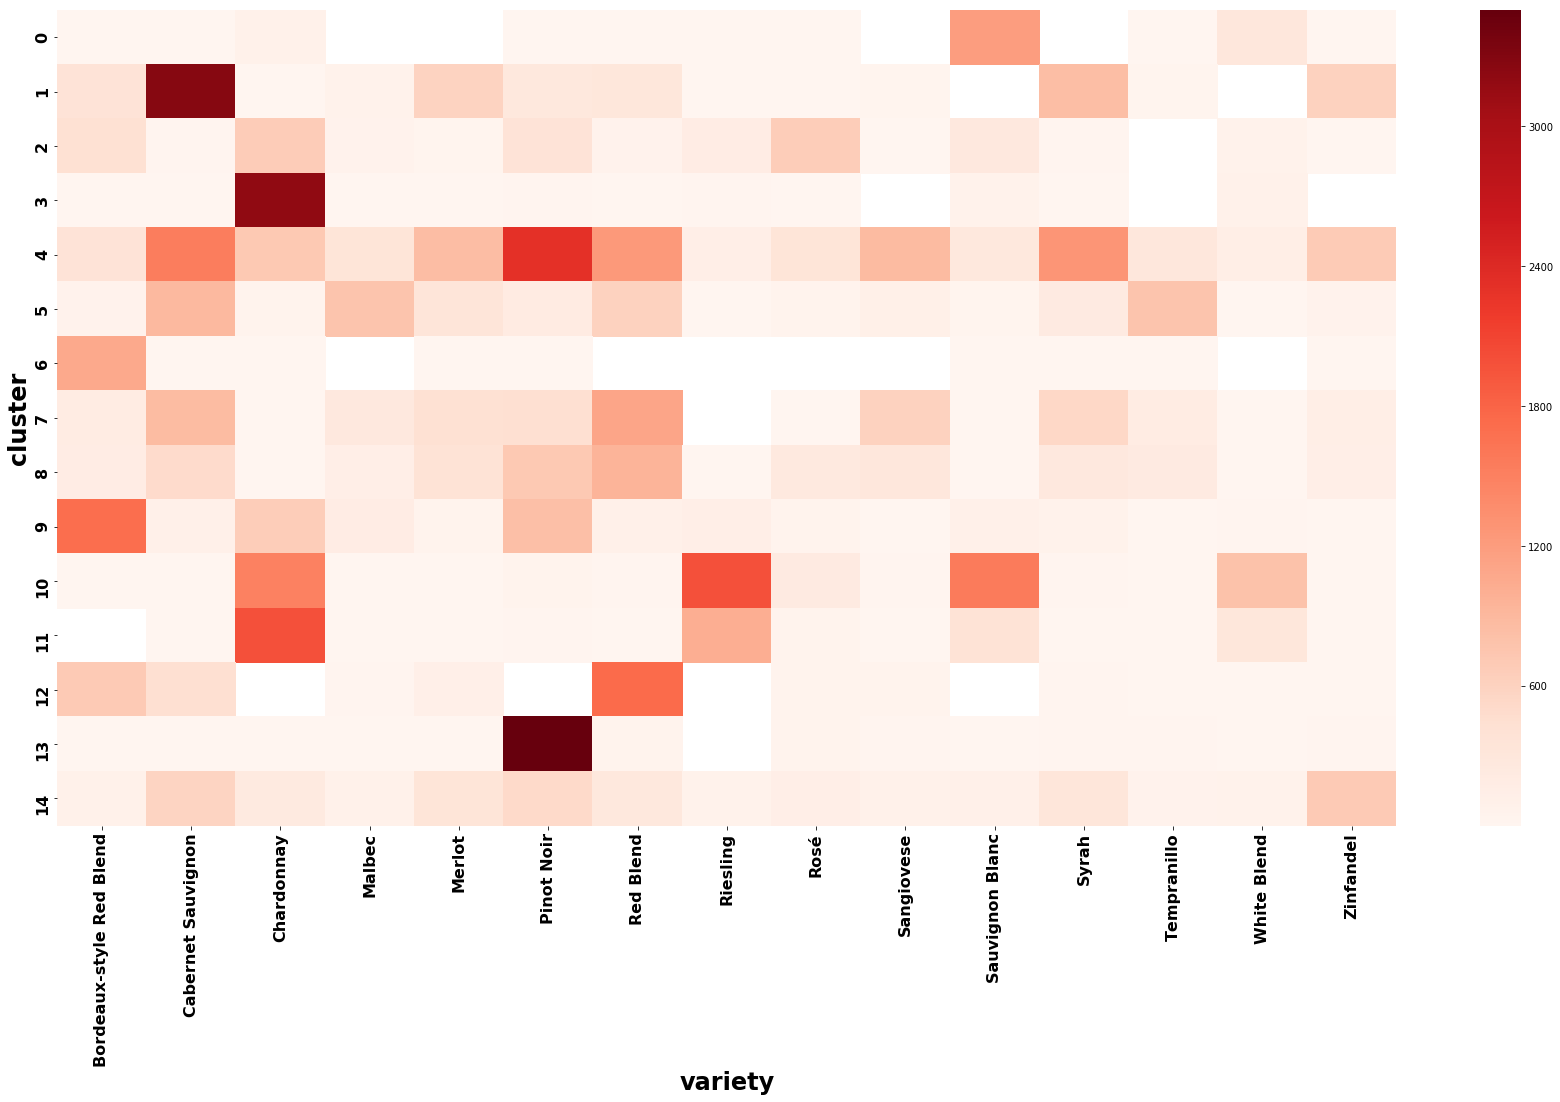

In [24]:
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

### Conclusion

Although kMeans didn't find a one-to-one relationship between each of the 15 wine types and clusters, we were still able to come up with clusters that greatly represented certain wines like Cabernet, Chardonay, Pinot Noir, and Riesling. This allows us to see how people are generally describing these kinds of wines, which is pretty cool! It might not have been the most useful in this case, but this type of analysis can definitely be done on other data involving reviews, etc. If we worked for a restaurant, we could determine what are some common things said in the reviews to help us know what we're doing right and what we're doing wrong so we can take action.


You also probably noticed that some of the descriptions actually had the wine name in them. I decided to keep these in because I was thinking that it would be easier to identify which words appeared more with certain wine varieties written in the description. The wine types can also be considered to be included in the stop words list.

Another thing to play with is the hyperparameter k i.e. the number of clusters we want the algorithm to group. For this case, I had an idea that 15 groups would be ideal since I had 15 different kinds of wine. There are many situations, however, where you don't really have an idea of how many you should pick. 8 is the default with sklearn but another way to determine k is through the use of an elbow plot, which involves the within cluster variance I mentioned earlier.

I'd like to consider with the dataset is using PCA to account for correlations in the token vectors. 

LASTLY, it'd be interesting to see how well the multinomial Bayes classification algorithm would perform with this dataset to predict wine varieties, country location, etc., based off the descriptions.